# ATL03 - Raw Photon data 

## data downloading
This data is downloaded for a section of the florida everglades.
This is an API endpoint that can be used to reproduce the dataset. 

some variables to include:
- dem_h - height relative to best DEM

Note:The JSON should probably be changed to netcdf

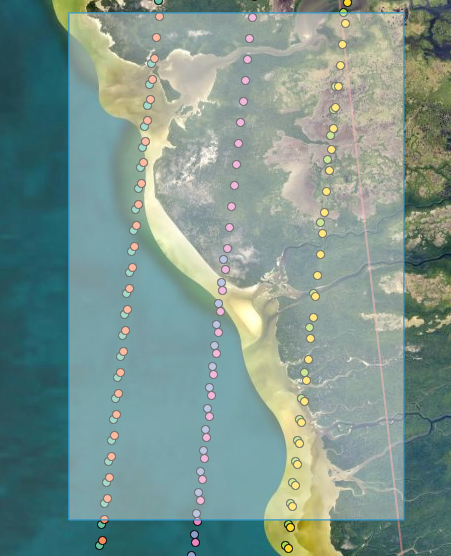


In [2]:
api_endpoint = "http://openaltimetry.org/data/api/icesat2/atl03?date=2021-12-12&minx=-81.23891365678568&miny=25.39587929292906&maxx=-81.12390053422709&maxy=25.56994392915953&trackId=1231&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json"


I predownloaded all the data for this site

## reading the data from the NetCDF

In [3]:
from netCDF4 import MFDataset,Dataset
import xarray as xr
%matplotlib widget

First we can check to see the structure of the nc dataset

In [4]:
atl03_testfile = (
    "../data/ATL03-test/223345351/processed_ATL03_20181206181537_10560101_005_01.nc"
)
ncds = Dataset(atl03_testfile)
print(ncds.groups.keys())
ncds.dimensions["ds_surf_type"]


dict_keys(['METADATA', 'ancillary_data', 'gt1l', 'gt1r', 'gt2l', 'gt2r'])


<class 'netCDF4._netCDF4.Dimension'>: name = 'ds_surf_type', size = 5

In [5]:
ncds.groups["gt1l"].groups["heights"].variables["h_ph"]


<class 'netCDF4._netCDF4.Variable'>
float32 h_ph(delta_time)
    long_name: Photon WGS84 Height
    standard_name: height
    units: meters
    source: ATL03g ATBD, Section 3.4
    contentType: physicalMeasurement
    description: Height of each received photon, relative to the WGS-84 ellipsoid including the geophysical corrections noted in Section 6. Please note that neither the geoid, ocean tide nor the dynamic atmosphere (DAC) corrections are applied to the ellipsoidal heights.
    coordinates: delta_time lat_ph lon_ph
path = /gt1l/heights
unlimited dimensions: 
current shape = (108635,)
filling off

In [6]:
# note: get netcdf3 next time
# MFDataset('../data/ATL03-test/*/*.nc',aggdim='ds_surf_type')


## reading data with xarray

In [7]:
ds = xr.open_dataset(atl03_testfile, group="gt1l/heights", decode_coords="all")


In [8]:
ds.h_ph.to_numpy().shape


(108635,)

In [9]:
ds = xr.open_dataset(atl03_testfile, group="gt1l/heights")

ds.where(ds.ds_surf_type == 2)


<xarray.Dataset>
Dimensions:         (delta_time: 108635, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2018-12-06T18:22:11.895757216...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time, ds_surf_type) float32 nan nan 408.6 ... nan nan
    dist_ph_along   (delta_time, ds_surf_type) float32 nan nan ... nan nan
    h_ph            (delta_time, ds_surf_type) float32 nan nan ... nan nan
    pce_mframe_cnt  (delta_time, ds_surf_type) float64 nan nan ... nan nan
    ph_id_channel   (delta_time, ds_surf_type) float64 nan nan 120.0 ... nan nan
    ph_id_count     (delta_time, ds_surf_type) float64 nan nan 2.0 ... nan nan
    ph_id_pulse     (delta_time, ds_surf_type) float64 nan nan 169.0 ... nan nan
    quality_ph      (delta_time, ds_surf_type) float64 nan nan 0.0 ... nan nan
    signal_conf_ph  (delta_time, ds_surf_type) float64 nan nan -1.0 ... nan nan
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

In [10]:
ds.assign_coords({"landsurface": ds.ds_surf_type})


<xarray.Dataset>
Dimensions:         (delta_time: 108635, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 2018-12-06T18:22:11.895757216...
    lat_ph          (delta_time) float64 ...
    lon_ph          (delta_time) float64 ...
    landsurface     (ds_surf_type) int64 0 1 2 3 4
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 ...
    dist_ph_along   (delta_time) float32 ...
    h_ph            (delta_time) float32 ...
    pce_mframe_cnt  (delta_time) uint32 ...
    ph_id_channel   (delta_time) uint8 ...
    ph_id_count     (delta_time) int8 ...
    ph_id_pulse     (delta_time) uint8 ...
    quality_ph      (delta_time) int8 ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

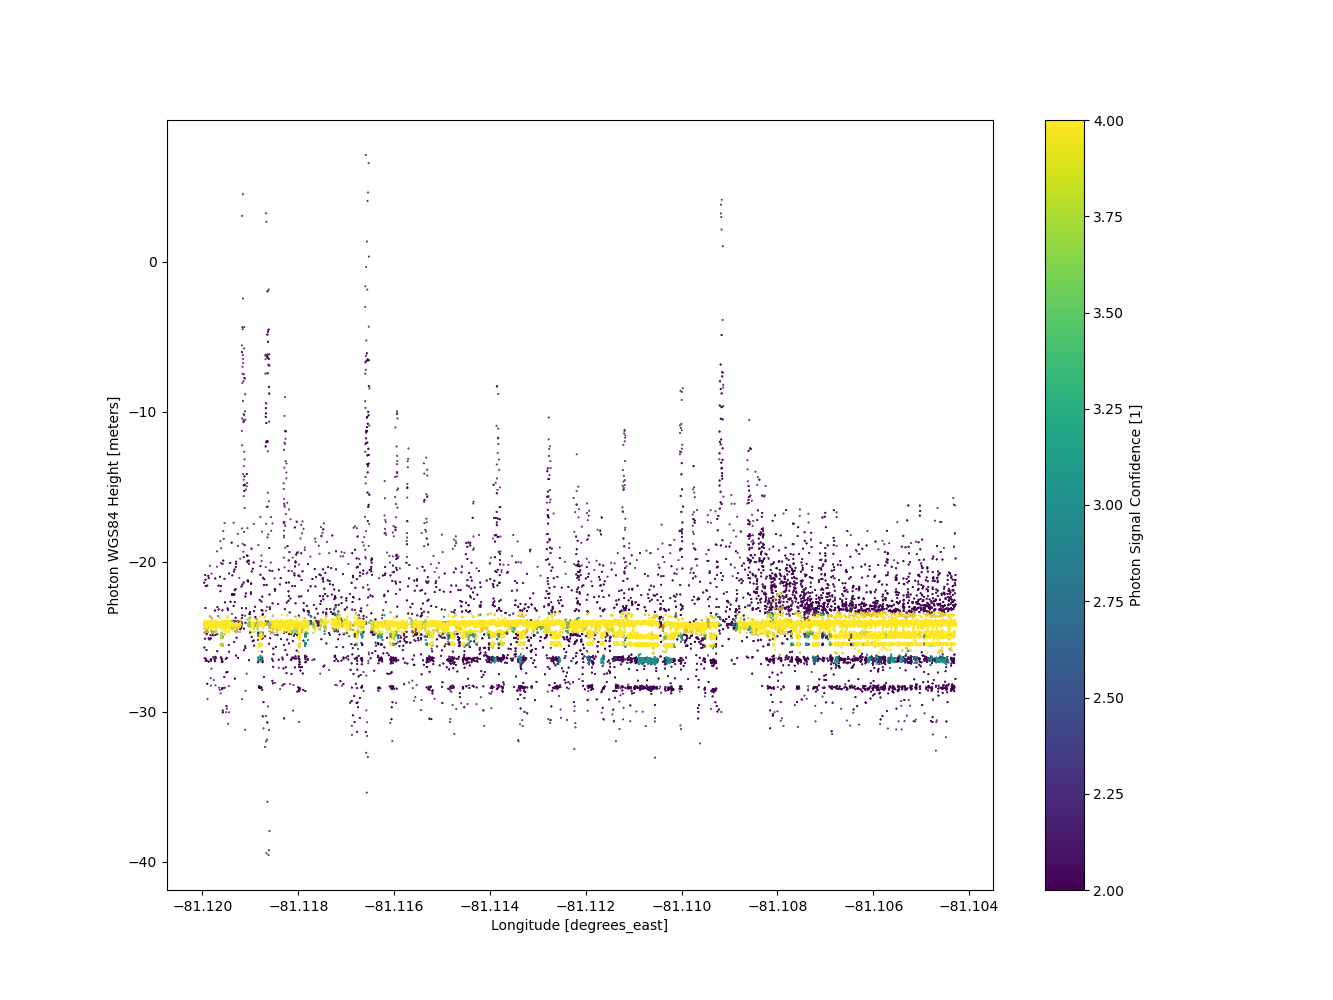

In [11]:
ds.where(ds.signal_conf_ph > 1).plot.scatter(
    x="lon_ph", y="h_ph", hue="signal_conf_ph", s=0.2, size=10
)


In [12]:
pointdf = ds.to_dataframe()
# get the data points there there is a high confidence of the predicted surface
highconf = pointdf[pointdf.signal_conf_ph == 4]


In [13]:
# learning an amazing new trick
pointdf.loc[pointdf.signal_conf_ph > 0].reset_index().query("ds_surf_type == [0,1,4]")


,delta_time,ds_surf_type,dist_ph_across,dist_ph_along,h_ph,lat_ph,lon_ph,pce_mframe_cnt,ph_id_channel,ph_id_count,ph_id_pulse,quality_ph,signal_conf_ph
0,2018-12-06 18:22:11.895757216,0,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
1,2018-12-06 18:22:11.895757216,1,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
2,2018-12-06 18:22:11.895757216,4,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
3,2018-12-06 18:22:11.895757216,0,408.577667,0.101535,-24.099108,25.268231,-81.104278,320031034,59,1,169,0,4
4,2018-12-06 18:22:11.895757216,1,408.577667,0.101535,-24.099108,25.268231,-81.104278,320031034,59,1,169,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
242560,2018-12-06 18:22:14.164557292,1,412.522247,19.893301,-24.199352,25.413264,-81.119963,320031148,58,2,57,0,4
242561,2018-12-06 18:22:14.164557292,4,412.522247,19.893301,-24.199352,25.413264,-81.119963,320031148,58,2,57,0,4
242562,2018-12-06 18:22:14.164557292,0,412.522125,19.893345,-24.124695,25.413264,-81.119963,320031148,59,2,57,0,4
242563,2018-12-06 18:22:14.164557292,1,412.522125,19.893345,-24.124695,25.413264,-81.119963,320031148,59,2,57,0,4


In [14]:
pointdf.query("ds_surf_type == [0,1,4]").query("signal_conf_ph > 0")


dist_ph_across  dist_ph_along  \
delta_time                    ds_surf_type                                  
2018-12-06 18:22:11.895757216 0                 408.577728       0.101583   
                              1                 408.577728       0.101583   
                              4                 408.577728       0.101583   
                              0                 408.577667       0.101535   
                              1                 408.577667       0.101535   
...                                                    ...            ...   
2018-12-06 18:22:14.164557292 1                 412.522247      19.893301   
                              4                 412.522247      19.893301   
                              0                 412.522125      19.893345   
                              1                 412.522125      19.893345   
                              4                 412.522125      19.893345   

                                                 h_ph     lat_ph     lon_ph  \
delta_time                    ds_surf_type                                    
2018-12-06 18:22:11.895757216 0            -24.130047  25.268231 -81.104278   
                              1            -24.130047  25.268231 -81.104278   
                              4            -24.130047  25.268231 -81.104278   
                              0            -24.099108  25.268231 -81.104278   
                              1            -24.099108  25.268231 -81.104278   
...                                               ...        ...        ...   
2018-12-06 18:22:14.164557292 1            -24.199352  25.413264 -81.119963   
                              4            -24.199352  25.413264 -81.119963   
                              0            -24.124695  25.413264 -81.119963   
                              1            -24.124695  25.413264 -81.119963   
                              4            -24.124695  25.413264 -81.119963   

                                            pce_mframe_cnt  ph_id_channel  \
delta_time                    ds_surf_type                                  
2018-12-06 18:22:11.895757216 0                  320031034            120   
                              1                  320031034            120   
                              4                  320031034            120   
                              0                  320031034             59   
                              1                  320031034             59   
...                                                    ...            ...   
2018-12-06 18:22:14.164557292 1                  320031148             58   
                              4                  320031148             58   
                              0                  320031148             59   
                              1                  320031148             59   
                              4                  320031148             59   

                                            ph_id_count  ph_id_pulse  \
delta_time                    ds_surf_type                             
2018-12-06 18:22:11.895757216 0                       2          169   
                              1                       2          169   
                              4                       2          169   
                              0                       1          169   
                              1                       1          169   
...                                                 ...          ...   
2018-12-06 18:22:14.164557292 1                       2           57   
                              4                       2           57   
                              0                       2           57   
                              1                       2           57   
                              4                       2           57   

                                            quality_ph  signal_conf_ph  
de

In [15]:
pts = (
    pointdf.loc[pointdf.quality_ph == 0].reset_index().query("ds_surf_type == [0,1,4]")
)
pts


,delta_time,ds_surf_type,dist_ph_across,dist_ph_along,h_ph,lat_ph,lon_ph,pce_mframe_cnt,ph_id_channel,ph_id_count,ph_id_pulse,quality_ph,signal_conf_ph
0,2018-12-06 18:22:11.895757216,0,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
1,2018-12-06 18:22:11.895757216,1,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
4,2018-12-06 18:22:11.895757216,4,408.577728,0.101583,-24.130047,25.268231,-81.104278,320031034,120,2,169,0,4
5,2018-12-06 18:22:11.895757216,0,408.577667,0.101535,-24.099108,25.268231,-81.104278,320031034,59,1,169,0,4
6,2018-12-06 18:22:11.895757216,1,408.577667,0.101535,-24.099108,25.268231,-81.104278,320031034,59,1,169,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
467391,2018-12-06 18:22:14.164557292,1,412.522247,19.893301,-24.199352,25.413264,-81.119963,320031148,58,2,57,0,4
467394,2018-12-06 18:22:14.164557292,4,412.522247,19.893301,-24.199352,25.413264,-81.119963,320031148,58,2,57,0,4
467395,2018-12-06 18:22:14.164557292,0,412.522125,19.893345,-24.124695,25.413264,-81.119963,320031148,59,2,57,0,4
467396,2018-12-06 18:22:14.164557292,1,412.522125,19.893345,-24.124695,25.413264,-81.119963,320031148,59,2,57,0,4


<AxesSubplot:xlabel='dist_ph_along', ylabel='h_ph'>

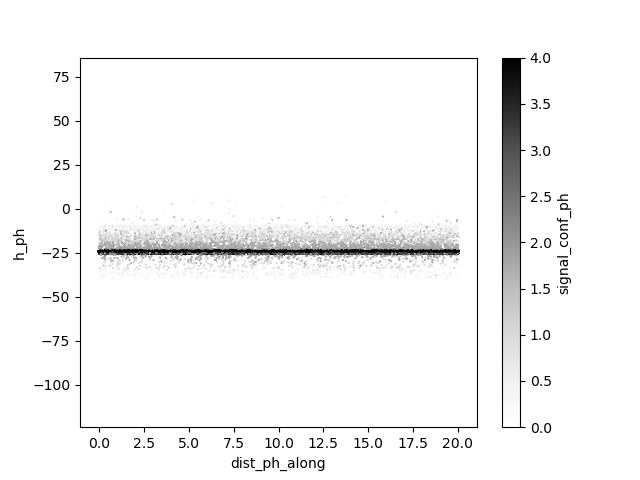

In [16]:
pts.plot.scatter(x="dist_ph_along", y="h_ph", c="signal_conf_ph", s=0.1)


## Using PDAL Pipelines

In [17]:
import pdal
import pandas as pd
import geopandas as gpd
import json
from enum import Enum
from shapely.geometry import LineString
import geemap
import xarray as xr

map_ = geemap.Map()


In [18]:
# i'm super lazy and just made this to autocomplete the beam names when typing
class Beams:
    gt1l = "gt1l"
    gt1r = "gt1r"
    gt2l = "gt2l"
    gt2r = "gt2r"
    gt3l = "gt3l"
    gt3r = "gt3r"


In [19]:
pipeline2 = pdal.pipeline.Reader.hdf(filename=atl03_testfile)


In [20]:
def write_pdal_pipeline(filename, beam):
    # TODO switch to the programmatic interface for pipeline construction
    # since i used an enum i need to coerece the beam into a string
    beam = str(beam)
    pipestring = f"""
[{{
        "type": "readers.hdf",
        "filename": "{filename}",
        "dimensions":
        {{
            "X" : "{beam}/heights/lon_ph",
            "Y" : "{beam}/heights/lat_ph",
            "Z" : "{beam}/heights/h_ph",
            "tr_d":"{beam}/heights/dist_ph_along"
        }}
    }}

]
"""
    return pipestring


In [21]:
def load_beam_array(filename, beam):
    """takes an ATL03 netCDF4 file, and a beam name as a string as an argument, returns a numpy array of the points of that beam"""
    pipelinejson = write_pdal_pipeline(filename, beam)
    pipelineobject = pdal.Pipeline(pipelinejson)
    try:
        pipelineobject.execute()
        return pipelineobject.arrays[0]
    except RuntimeError:
        print(f"Beam {beam} missing from {filename}")


def get_track_gdf(outarray):
    coords = [
        [outarray["X"].min(), outarray["Y"].min()],
        [outarray["X"].max(), outarray["Y"].max()],
    ]
    # print(coords)
    linegeom = LineString(coords)
    return gpd.GeoDataFrame(
        {"geometry": [linegeom]}, crs="EPSG:7912", geometry="geometry"
    )


def get_track_geom(outarray):
    if array is not None:
        coords = [
            [outarray["X"].min(), outarray["Y"].min()],
            [outarray["X"].max(), outarray["Y"].max()],
        ]
        # print(coords)
        return LineString(coords)


In [22]:
gt1l = load_beam_array(atl03_testfile, Beams.gt1l)

xr.DataArray(gt1l)


<xarray.DataArray (dim_0: 108635)>
array([(-81.10427765, 25.26823088, -24.13004684,  0.1015834 ),
       (-81.10427765, 25.26823088, -24.09910774,  0.10153469),
       (-81.10427832, 25.26823729, -24.15833473,  0.81430006), ...,
       (-81.11996321, 25.41326386, -24.19935226, 19.893301  ),
       (-81.11996321, 25.41326386, -24.12469482, 19.893345  ),
       (-81.1199636 , 25.41326365, -50.71679306, 19.874195  )],
      dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('tr_d', '<f4')])
Dimensions without coordinates: dim_0

In [23]:
geodf = get_track_gdf(gt1l)


In [24]:
beamlist = ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
beamcords = {}
for beam in beamlist:
    array = load_beam_array(atl03_testfile, beam)
    beamcords[beam] = get_track_geom(array)


Beam gt3l missing from ../data/ATL03-test/223345351/processed_ATL03_20181206181537_10560101_005_01.nc
Beam gt3r missing from ../data/ATL03-test/223345351/processed_ATL03_20181206181537_10560101_005_01.nc


In [25]:
geodef = gpd.GeoDataFrame(
    {"beam_name": beamlist, "geometry": beamcords.values()}, geometry="geometry"
)
map_.add_gdf(geodf)
map_


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

<AxesSubplot:xlabel='tr_d', ylabel='Z'>

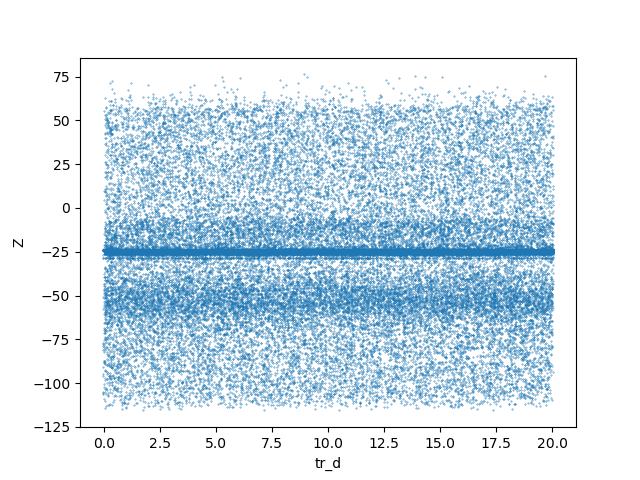

In [26]:
pd.DataFrame(gt1l).plot.scatter(x="tr_d", y="Z", s=0.1)


In [27]:
from sklearn.cluster import DBSCAN
import numpy as np

In [28]:
stacked = np.stack([gt1l['tr_d'],gt1l['Z']]).transpose()
stacked

array([[  0.1015834 , -24.13004684],
       [  0.10153469, -24.09910774],
       [  0.81430006, -24.15833473],
       ...,
       [ 19.89330101, -24.19935226],
       [ 19.89334488, -24.12469482],
       [ 19.8741951 , -50.71679306]])

[ 0  0  0 ...  0  0 -1]
X          108635
Y          108635
Z           99530
tr_d        95442
cluster         2
dtype: int64


<AxesSubplot:xlabel='tr_d', ylabel='Z'>

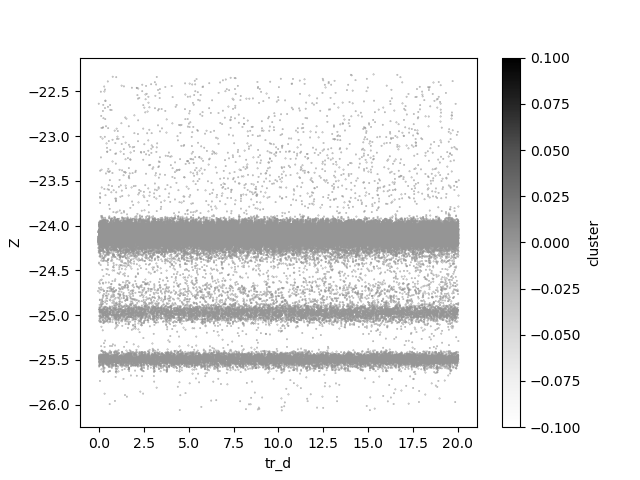

In [32]:
# cluster and plot the results
clustering = DBSCAN(eps=1,min_samples=3000).fit(stacked)
df = pd.DataFrame(gt1l).assign(cluster=clustering.labels_)
print(clustering.labels_)
print(df.nunique())
df[df.cluster==0].plot.scatter(x='tr_d',y='Z',c='cluster',s=0.1)